In [1]:
from glob import glob
import numpy as np

import skimage
import skimage.io
import skimage.filters
import skimage.draw

In [2]:
class ImageClass:
  def image(file):
    image = skimage.io.imread(file, as_gray=True)
    # uint8 to float64
    image = image.astype(np.float64)
    return image

  def gaussionBlur(image,r):
    return skimage.filters.gaussian(image,sigma=r)


  def save(image,file):
    # float64 to uint8
    
    skimage.io.imsave(file, _image)
    return _image

  def circle(image,centerx,centery,r):
    x, y = skimage.draw.circle_perimeter( centery , centerx , r )
    image[x,y] = 1
    return image

In [3]:
class IrisFinder(ImageClass):
  def Daugman(image,x,y,min_r,max_r,step=1):
    """
      Calculate       
                              ∂  ∮  I(x,y)  ds
      Max(r,x,y) = Gσ (r) ∗ ------------------
                              ∂r     2πr
      : image : image
      : x : x coordinate
      : y : y coordinate
      : min_r : min radius
      : max_r : max radius
    """

    height, width = image.shape[:2]
    
    
    # values = list of r distance ( ∮ I(x,y) ds ) 
    values = []
    for r in range(min_r,max_r,step):  
      # _value = ∮ I(x,y) ds
      _angle_step=24
      _value = 0
      for i in range(0,_angle_step*2):
        _value = _value + image[ int(y + r * np.sin(i*np.pi/_angle_step)) , int(x + r * np.cos(i*np.pi/_angle_step)) ]
      _value = _value / ( 256 * _angle_step * 2)
      #circle = skimage.draw.circle_perimeter( y , x , r )
      #_value = np.add.reduce( image[circle] / 256  ) / (2 * 3.1415 * r)
      values.append(_value)
      #values[r] = _value
    
    # print(values)
    # ∂ / ∂r _values
    values = np.array(values, dtype=np.float32)
    values = values[1:] - values[:-1] 
    # print(values)
    
    # Gσ (r)
    gauss=abs(skimage.filters.gaussian(values,sigma=0.5 ))
    # print(gauss)
    # index of max value ( radius )
    index = np.argmax(gauss)
    # max value
    _max = np.max(gauss)
    # radius
    radius = range(min_r,max_r,step)[index]
    return _max,radius

  def FindIrisList(image, min_r,max_r,step=1,pxStep=1):
    height, width = image.shape[:2]
    print("height : ",height, "width : ",width)
    _list = []
    for y in range( max_r, height-max_r , pxStep ):
      for x in range( max_r, width-max_r, pxStep ):
        _cross = min( y , x , height - y , width - x )
        _max_r = min( max_r , _cross )
        if _max_r < min_r + 3: continue

        _value,_radius = IrisFinder.Daugman(image,x,y,min_r, _max_r,step)
        _list.append( (x,y,_radius,_value) )
    
    # sort list by value
    _list = sorted(_list, key=lambda x: x[3], reverse=True)
    return _list[0:10]

  def FindIris(image, min_r,max_r,step=1,pxStep=1):
    _list = IrisFinder.FindIrisList(image, min_r,max_r,step,pxStep)
    value = (_list[0][0],_list[0][1]), _list[0][2]
    print("Circle finded:",value)
    return value


In [4]:
def scan(PATH,save):
  #PATH = "UBIRIS_200_150_R/Sessao_1/5/Img_5_1_1.jpg"
  #PATH = "eye.jpeg"

  imageSafe = ImageClass.image(PATH)
  image = ImageClass.image(PATH)
  image = ImageClass.gaussionBlur(image,2)

  height, width = image.shape[:2]
  size = min(height,width)
  # Auto size from image
  step = 1 # 1 -> Slow & More Correct , 5 -> Fast & Less Correct
  _min = int(size*0.15)
  _max = int(size*0.45)

  # Test
  #_min = 40
  #_max = 70


  print("Min:",_min,"Max:",_max,"Step:",step)

  # Test
  """
  for circle in IrisFinder.FindIrisList(image,_min, _max, step, 4 ):
    print(circle)
    IrisFinder.circle(imageSafe,circle[0],circle[1],circle[2])
  IrisFinder.save(imageSafe,'eye_circle.jpeg')
  exit()
  """
  #iris center, iris radius
  ic, ir = IrisFinder.FindIris(image,_min, _max, step, 5 )

  image_iris = image[ic[1]-ir:ic[1]+ir,ic[0]-ir:ic[0]+ir]

  print("pupil:"+str(ir))
  
  pc, pr = IrisFinder.FindIris(image_iris,int(round(ir * 0.2)),int(round(ir * 0.7)), step, 1 )
  #IrisFinder.save( IrisFinder.circle(imageSafe[ic[1]-ir:ic[1]+ir,ic[0]-ir:ic[0]+ir],pc[0],pc[1],pr) , 'pupil_circle.jpeg' )

  pc = ( pc[0] + ic[0] - ir , pc[1] + ic[1] - ir )

  print(pc,pr)

  #IrisFinder.circle(imageSafe,ic[0],ic[1],ir)
  #IrisFinder.circle(imageSafe,pc[0],pc[1],pr)

  #IrisFinder.save(imageSafe,'eye_circle.jpeg')


  ## Gray To RGB
  rgb = skimage.color.gray2rgb(imageSafe)
  ## Red Circle Iris
  rgb[ skimage.draw.circle_perimeter(ic[1],ic[0],ir ) ] = (255.0,0.0,0.0)
  ## Yellow Circle Pupil
  rgb[ skimage.draw.circle_perimeter(pc[1],pc[0],pr ) ] = (100.0,255.0,0.0)
  # Save 
  skimage.io.imsave(save,rgb)


In [5]:
files=glob("UBIRIS_200_150_R/Sessao_1/*/*.jpg")
print(files)

for i,f in enumerate(files):
  scan(f,"scan/scan-"+str(i)+".jpg")
  print(f,i)

['UBIRIS_200_150_R/Sessao_1\\1\\Img_1_1_1.jpg', 'UBIRIS_200_150_R/Sessao_1\\1\\Img_1_1_2.jpg', 'UBIRIS_200_150_R/Sessao_1\\1\\Img_1_1_3.jpg', 'UBIRIS_200_150_R/Sessao_1\\1\\Img_1_1_4.jpg', 'UBIRIS_200_150_R/Sessao_1\\1\\Img_1_1_5.jpg', 'UBIRIS_200_150_R/Sessao_1\\10\\Img_10_1_1.jpg', 'UBIRIS_200_150_R/Sessao_1\\10\\Img_10_1_2.jpg', 'UBIRIS_200_150_R/Sessao_1\\10\\Img_10_1_3.jpg', 'UBIRIS_200_150_R/Sessao_1\\10\\Img_10_1_4.jpg', 'UBIRIS_200_150_R/Sessao_1\\10\\Img_10_1_5.jpg', 'UBIRIS_200_150_R/Sessao_1\\100\\Img_100_1_1.jpg', 'UBIRIS_200_150_R/Sessao_1\\100\\Img_100_1_2.jpg', 'UBIRIS_200_150_R/Sessao_1\\100\\Img_100_1_3.jpg', 'UBIRIS_200_150_R/Sessao_1\\100\\Img_100_1_4.jpg', 'UBIRIS_200_150_R/Sessao_1\\100\\Img_100_1_5.jpg', 'UBIRIS_200_150_R/Sessao_1\\101\\Img_101_1_1.jpg', 'UBIRIS_200_150_R/Sessao_1\\101\\Img_101_1_2.jpg', 'UBIRIS_200_150_R/Sessao_1\\101\\Img_101_1_3.jpg', 'UBIRIS_200_150_R/Sessao_1\\101\\Img_101_1_4.jpg', 'UBIRIS_200_150_R/Sessao_1\\101\\Img_101_1_5.jpg', 'UBIRIS_2

Circle finded: ((102, 77), 49)
pupil:49
height :  98 width :  98


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Circle finded: ((50, 47), 11)
(103, 75) 11
UBIRIS_200_150_R/Sessao_1\1\Img_1_1_1.jpg 0
Min: 22 Max: 67 Step: 1
height :  150 width :  200
Circle finded: ((102, 77), 49)
pupil:49
height :  98 width :  98


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Circle finded: ((49, 49), 11)
(102, 77) 11
UBIRIS_200_150_R/Sessao_1\1\Img_1_1_2.jpg 1
Min: 22 Max: 67 Step: 1
height :  150 width :  200
Circle finded: ((102, 82), 49)
pupil:49
height :  98 width :  98


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Circle finded: ((49, 45), 11)
(102, 78) 11
UBIRIS_200_150_R/Sessao_1\1\Img_1_1_3.jpg 2
Min: 22 Max: 67 Step: 1
height :  150 width :  200
Circle finded: ((97, 72), 49)
pupil:49
height :  98 width :  98


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Circle finded: ((51, 50), 12)
(99, 73) 12
UBIRIS_200_150_R/Sessao_1\1\Img_1_1_4.jpg 3
Min: 22 Max: 67 Step: 1
height :  150 width :  200
Circle finded: ((97, 77), 49)
pupil:49
height :  98 width :  98


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Circle finded: ((51, 50), 11)
(99, 78) 11
UBIRIS_200_150_R/Sessao_1\1\Img_1_1_5.jpg 4
Min: 22 Max: 67 Step: 1
height :  150 width :  200
Circle finded: ((97, 77), 45)
pupil:45
height :  90 width :  90


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Circle finded: ((47, 43), 11)
(99, 75) 11
UBIRIS_200_150_R/Sessao_1\10\Img_10_1_1.jpg 5
Min: 22 Max: 67 Step: 1
height :  150 width :  200
Circle finded: ((102, 82), 45)
pupil:45
height :  90 width :  90


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Circle finded: ((44, 40), 11)
(101, 77) 11
UBIRIS_200_150_R/Sessao_1\10\Img_10_1_2.jpg 6
Min: 22 Max: 67 Step: 1
height :  150 width :  200
Circle finded: ((97, 82), 45)
pupil:45
height :  90 width :  90


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Circle finded: ((46, 41), 11)
(98, 78) 11
UBIRIS_200_150_R/Sessao_1\10\Img_10_1_3.jpg 7
Min: 22 Max: 67 Step: 1
height :  150 width :  200
Circle finded: ((97, 82), 45)
pupil:45
height :  90 width :  90


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Circle finded: ((45, 42), 11)
(97, 79) 11
UBIRIS_200_150_R/Sessao_1\10\Img_10_1_4.jpg 8
Min: 22 Max: 67 Step: 1
height :  150 width :  200
Circle finded: ((92, 82), 46)
pupil:46
height :  92 width :  92


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Circle finded: ((50, 43), 11)
(96, 79) 11
UBIRIS_200_150_R/Sessao_1\10\Img_10_1_5.jpg 9
Min: 22 Max: 67 Step: 1
height :  150 width :  200
Circle finded: ((102, 72), 45)
pupil:45
height :  90 width :  90


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Circle finded: ((49, 45), 11)
(106, 72) 11
UBIRIS_200_150_R/Sessao_1\100\Img_100_1_1.jpg 10
Min: 22 Max: 67 Step: 1
height :  150 width :  200
Circle finded: ((107, 72), 45)
pupil:45
height :  90 width :  90


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Circle finded: ((46, 44), 11)
(108, 71) 11
UBIRIS_200_150_R/Sessao_1\100\Img_100_1_2.jpg 11
Min: 22 Max: 67 Step: 1
height :  150 width :  200
Circle finded: ((107, 72), 46)
pupil:46
height :  92 width :  92


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Circle finded: ((49, 46), 11)
(110, 72) 11
UBIRIS_200_150_R/Sessao_1\100\Img_100_1_3.jpg 12
Min: 22 Max: 67 Step: 1
height :  150 width :  200
Circle finded: ((107, 72), 46)
pupil:46
height :  92 width :  92


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Circle finded: ((48, 46), 12)
(109, 72) 12
UBIRIS_200_150_R/Sessao_1\100\Img_100_1_4.jpg 13
Min: 22 Max: 67 Step: 1
height :  150 width :  200
Circle finded: ((107, 72), 46)
pupil:46
height :  92 width :  92


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Circle finded: ((49, 47), 11)
(110, 73) 11
UBIRIS_200_150_R/Sessao_1\100\Img_100_1_5.jpg 14
Min: 22 Max: 67 Step: 1
height :  150 width :  200
Circle finded: ((92, 82), 36)
pupil:36
height :  72 width :  72


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Circle finded: ((46, 40), 8)
(102, 86) 8
UBIRIS_200_150_R/Sessao_1\101\Img_101_1_1.jpg 15
Min: 22 Max: 67 Step: 1
height :  150 width :  200
Circle finded: ((92, 82), 36)
pupil:36
height :  72 width :  72


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Circle finded: ((46, 42), 8)
(102, 88) 8
UBIRIS_200_150_R/Sessao_1\101\Img_101_1_2.jpg 16
Min: 22 Max: 67 Step: 1
height :  150 width :  200
Circle finded: ((92, 82), 36)
pupil:36
height :  72 width :  72


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Circle finded: ((46, 43), 8)
(102, 89) 8
UBIRIS_200_150_R/Sessao_1\101\Img_101_1_3.jpg 17
Min: 22 Max: 67 Step: 1
height :  150 width :  200
Circle finded: ((92, 82), 36)
pupil:36
height :  72 width :  72


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Circle finded: ((46, 43), 8)
(102, 89) 8
UBIRIS_200_150_R/Sessao_1\101\Img_101_1_4.jpg 18
Min: 22 Max: 67 Step: 1
height :  150 width :  200
Circle finded: ((107, 82), 46)
pupil:46
height :  92 width :  92


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Circle finded: ((46, 48), 11)
(107, 84) 11
UBIRIS_200_150_R/Sessao_1\101\Img_101_1_5.jpg 19
Min: 22 Max: 67 Step: 1
height :  150 width :  200
Circle finded: ((97, 77), 47)
pupil:47
height :  94 width :  94


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Circle finded: ((51, 47), 13)
(101, 77) 13
UBIRIS_200_150_R/Sessao_1\102\Img_102_1_1.jpg 20
Min: 22 Max: 67 Step: 1
height :  150 width :  200
Circle finded: ((102, 82), 45)
pupil:45
height :  90 width :  90


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Circle finded: ((47, 41), 12)
(104, 78) 12
UBIRIS_200_150_R/Sessao_1\102\Img_102_1_2.jpg 21
Min: 22 Max: 67 Step: 1
height :  150 width :  200
Circle finded: ((102, 82), 45)
pupil:45
height :  90 width :  90


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Circle finded: ((48, 41), 12)
(105, 78) 12
UBIRIS_200_150_R/Sessao_1\102\Img_102_1_3.jpg 22
Min: 22 Max: 67 Step: 1
height :  150 width :  200
Circle finded: ((102, 77), 45)
pupil:45
height :  90 width :  90


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Circle finded: ((48, 44), 12)
(105, 76) 12
UBIRIS_200_150_R/Sessao_1\102\Img_102_1_4.jpg 23
Min: 22 Max: 67 Step: 1
height :  150 width :  200
Circle finded: ((102, 77), 45)
pupil:45
height :  90 width :  90


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Circle finded: ((48, 43), 12)
(105, 75) 12
UBIRIS_200_150_R/Sessao_1\102\Img_102_1_5.jpg 24
Min: 22 Max: 67 Step: 1
height :  150 width :  200


KeyboardInterrupt: 



```
# Bu, kod olarak biçimlendirilmiştir
```

# SONUÇ ANALİZİ


> Girintili blok



**Toplam 1214 tane sonuç resmi elde edilmiştir.**



**SONUCU ETKİLEYEN FAKTÖRLER**



*   İRİS

1.   Göz kapağının iris üzerinde fazla oranda bulunması.
2.   İris üzerindeki kirpik sayısının fazlalığı.
3.   Resmin net olmaması.





*   GÖZ BEBEĞİ

1.   İris ve göz bebeğinin gri tonlamasının aynı düzeyde olması.
2.   Göz kapağının göz bebeğinin görünmeyecek kadar kapalı olması.
3.   Resmin net olmaması.
4.   Göz bebeğinin parlama oranının yüksek olması.






**Sıralanan faktörlere sahip olan resimler başarısız olmuştur.**

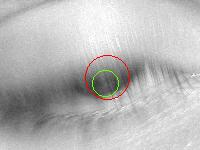


**Göz kapağının iris üzerinde fazla oranda bulunması durumu.**

*İris ve göz bebeği başarısız!*



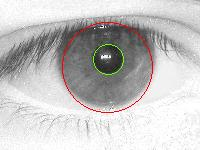

**İris üzerindeki kirpik sayısının fazlalığı.**

*İris başarısız!*

*Göz bebeği başarılı!*

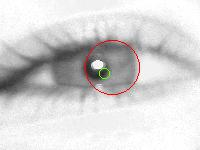



**Resmin net olmaması durumu.**

*İris ve göz bebeği başarısız!*





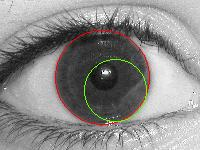



**İris ve göz bebeğinin gri tonlamasının aynı düzeyde olması durumu.**

*İris başarılı!*

*Göz bebeği başarısız!*

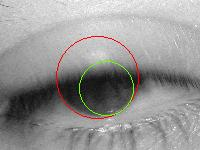


**Göz kapağının göz bebeğinin görünmeyecek kadar kapalı olması durumu.**

*İris başarılı!*

*Göz bebeği başarısız!*

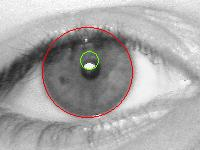

**Göz bebeğinin parlama oranının yüksek olması durumu.**

*İris başarılı!*

*Göz bebeği başarısız!*

**İris Ve Göz Bebeği İçin Başarılı Sonuçlardan Örnekler**
---

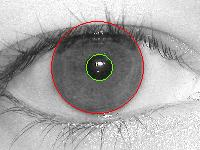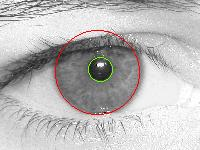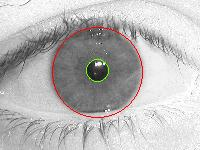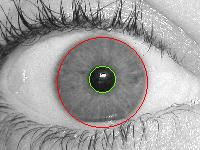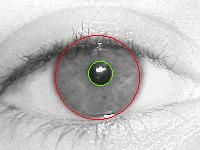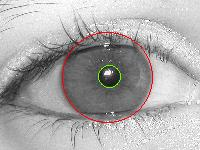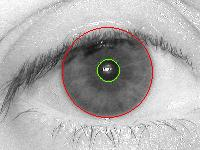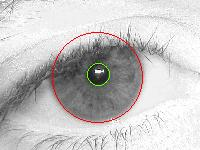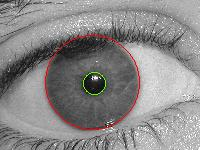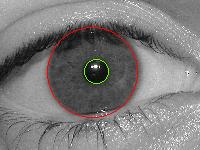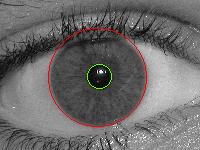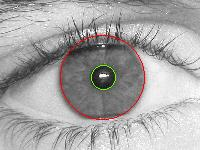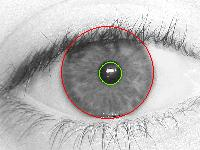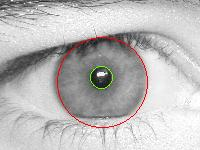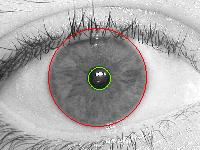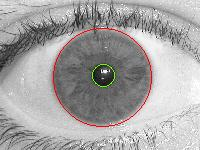
